In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Lambda
from keras.layers import Bidirectional, BatchNormalization, concatenate, GRU, Embedding
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import sys
sys.path.insert(0, '/home/david/Galvanize/capstones/music_genres/src')
from helper_funcs import *

Using TensorFlow backend.


In [2]:
genre_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }
reverse_dict = {v: k for k, v in genre_dict.items()}

In [3]:
npzfile = np.load('../saved_variables/train.npz')
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [4]:
npzfile = np.load('../saved_variables/validation.npz')
X_val = npzfile['arr_0']
y_val = npzfile['arr_1']
print(X_val.shape, y_val.shape)

(800, 640, 128) (800, 8)


In [5]:
npzfile = np.load('../saved_variables/test.npz')
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

(800, 640, 128) (800,)


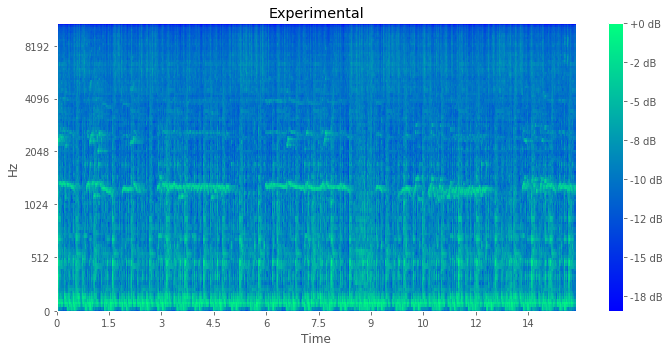

In [6]:
spectogram = X_train[5]
genre = np.argmax(y_train[5])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time', cmap='winter')
plt.colorbar(format='%+2.0f dB')
plt.title(reverse_dict[genre])
plt.tight_layout()

In [7]:
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]
n_layers = 3
filter_length = 5
conv_filter_count = 56
batch_size = 32
lstm_count = 96
epoch_count = 70
n_hidden = 64
L2_regularization = 0.001
input_shape = (None, n_features)
model_input = Input(input_shape, name='input')
print('Building model...')
layer = model_input
for i in range(n_layers):
    layer = Conv1D(
            filters=conv_filter_count,
            kernel_size=filter_length,
            kernel_regularizer=regularizers.l2(L2_regularization),
            name='convolution_' + str(i + 1)
        )(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling1D(2)(layer)
    layer = Dropout(0.4)(layer)
layer = LSTM(lstm_count, return_sequences=False)(layer)
layer = Dropout(0.4)(layer)
layer = Dense(n_hidden, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
layer = Dropout(0.4)(layer)
layer = Dense(num_classes)(layer)
layer = Activation('softmax', name='output_realtime')(layer)
model_output = layer
crnn_model = Model(model_input, model_output)
crnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
print(crnn_model.summary())
checkpoint_callback = ModelCheckpoint('../saved_variables/crnn_weights.best.hdf5', monitor='val_accuracy', 
                                      verbose=1, save_best_only=True, mode='max')
reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, 
                                      min_delta=0.01, verbose=1)
print('Training...')
# crnn_history = crnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_count,
#                     validation_data=(X_val, y_val), verbose=1, 
#                     callbacks=[checkpoint_callback, reducelr_callback])

Building model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 56)          224       
_________________________________________________________________
activation_1 (Activation)    (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 56)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None,

In [ ]:
plt.plot(crnn_history.history['accuracy'])
plt.plot(crnn_history.history['val_accuracy'])
plt.title('CRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../images/crnn_acc.png')

In [ ]:
plt.plot(crnn_history.history['loss'])
plt.plot(crnn_history.history['val_loss'])
plt.title('CRNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../images/crnn_loss.png')

In [234]:
crnn_model = load_model('../saved_variables/crnn_weights.hdf5')

In [27]:
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(crnn_model.predict(X_val), axis=1)
print(classification_report(y_true, y_pred, labels=list(genre_dict.values()), target_names=genre_dict.keys()))

               precision    recall  f1-score   support

   Electronic       0.53      0.36      0.43       100
 Experimental       0.41      0.54      0.47       100
         Folk       0.54      0.82      0.65       100
      Hip-Hop       0.64      0.81      0.71       100
 Instrumental       0.44      0.41      0.42       100
International       0.72      0.66      0.69       100
          Pop       0.10      0.07      0.08       100
         Rock       0.81      0.54      0.65       100

     accuracy                           0.53       800
    macro avg       0.52      0.53      0.51       800
 weighted avg       0.52      0.53      0.51       800



In [28]:
print(accuracy_score(y_true, y_pred))

0.52625


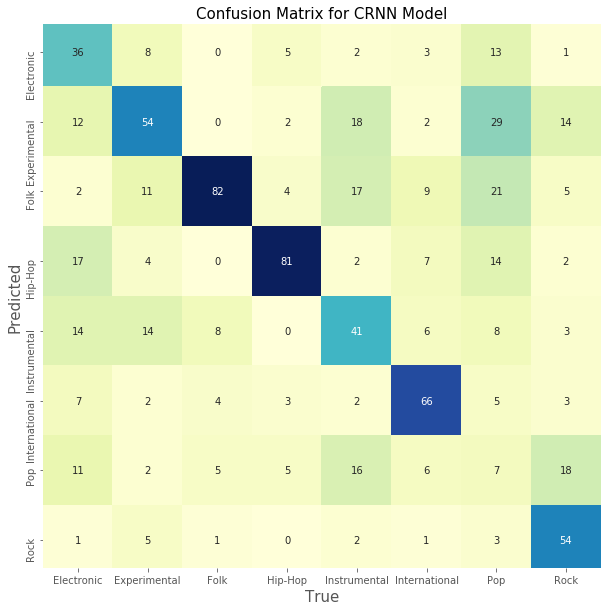

In [30]:
mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlGnBu',
            xticklabels=genre_dict.keys(),
            yticklabels=genre_dict.keys(), ax=ax)
plt.xlabel('True', size=15)
plt.ylabel('Predicted', size=15)
plt.title('Confusion Matrix for CRNN Model', size=15)
ax.set_ylim(8-0.1, 0.1)
plt.savefig('../images/crnn_conf_mat.png')

In [6]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)
dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120
batch_size = 64
epoch_count = 50
L2_regularization = 0.001
n_frequency = 128
n_frames = 640
X_train = np.expand_dims(X_train, axis = -1)
X_val = np.expand_dims(X_val, axis = -1)
input_shape = (n_frames, n_frequency, 1)
model_input = Input(input_shape, name='input')
print('Building model...')
# CNN
layer = model_input
conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                  padding= 'valid', activation='relu', name='conv_1')(layer)
pool_1 = MaxPooling2D(pool_size_1)(conv_1)
conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                  padding= 'valid', activation='relu', name='conv_2')(pool_1)
pool_2 = MaxPooling2D(pool_size_1)(conv_2)
conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                  padding= 'valid', activation='relu', name='conv_3')(pool_2)
pool_3 = MaxPooling2D(pool_size_1)(conv_3)
conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                  padding= 'valid', activation='relu', name='conv_4')(pool_3)
pool_4 = MaxPooling2D(pool_size_2)(conv_4)
conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                  padding= 'valid', activation='relu', name='conv_5')(pool_4)
pool_5 = MaxPooling2D(pool_size_2)(conv_5)
flatten1 = Flatten()(pool_5)
# RNN
pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
squeezed = Lambda(lambda x: backend.squeeze(x, axis= -1))(pool_lstm1)
lstm = Bidirectional(GRU(lstm_count))(squeezed)
# Concat
concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
model_output = output
cnn_rnn_model = Model(model_input, model_output)
cnn_rnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), 
                      metrics=['accuracy'])
print(cnn_rnn_model.summary())
checkpoint_callback = ModelCheckpoint('../saved_variables/cnn_rnn_weights.best.hdf5', 
                                      monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, 
                                      min_delta=0.01, verbose=1)
print('Training...')
# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_count,
#                     validation_data=(X_val, y_val), verbose=1, 
#                     callbacks=[checkpoint_callback, reducelr_callback])

Building model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 640, 128, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 638, 128, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 319, 64, 16)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 317, 64, 32)  1568        max_pooling2d_1[0][0]            
__________________________________________________________________________

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN-RNN Parallel Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../images/cnn_rnn_acc.png')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-RNN Parallel Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('../images/cnn_rnn_loss.png')

In [7]:
cnn_rnn_model = load_model('../saved_variables/cnn_rnn_weights.hdf5')

In [8]:
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(cnn_rnn_model.predict(X_val), axis=1)
print(classification_report(y_true, y_pred, labels=list(genre_dict.values()), target_names=genre_dict.keys()))

               precision    recall  f1-score   support

   Electronic       0.48      0.58      0.52       100
 Experimental       0.40      0.51      0.45       100
         Folk       0.63      0.74      0.68       100
      Hip-Hop       0.57      0.66      0.61       100
 Instrumental       0.69      0.45      0.55       100
International       0.71      0.57      0.63       100
          Pop       0.16      0.11      0.13       100
         Rock       0.65      0.67      0.66       100

     accuracy                           0.54       800
    macro avg       0.54      0.54      0.53       800
 weighted avg       0.54      0.54      0.53       800



In [9]:
print(accuracy_score(y_true, y_pred))

0.53625


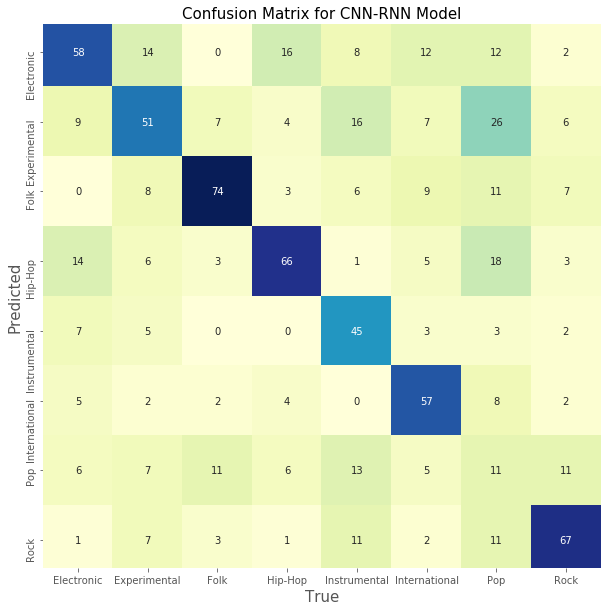

In [10]:
mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlGnBu',
            xticklabels=genre_dict.keys(),
            yticklabels=genre_dict.keys(), ax=ax)
plt.xlabel('True', size=15)
plt.ylabel('Predicted', size=15)
plt.title('Confusion Matrix for CNN-RNN Model', size=15)
ax.set_ylim(8-0.1, 0.1)
plt.savefig('../images/cnn_rnn_conf_mat.png')

In [11]:
y_true = y_test
X_test = np.expand_dims(X_test, axis= -1)
y_pred = np.argmax(cnn_rnn_model.predict(X_test), axis=1)
print(classification_report(y_true, y_pred, labels=list(genre_dict.values()), target_names=genre_dict.keys()))

               precision    recall  f1-score   support

   Electronic       0.54      0.52      0.53       100
 Experimental       0.26      0.32      0.29       100
         Folk       0.32      0.35      0.33       100
      Hip-Hop       0.55      0.85      0.67       100
 Instrumental       0.56      0.33      0.42       100
International       0.60      0.58      0.59       100
          Pop       0.23      0.21      0.22       100
         Rock       0.64      0.46      0.53       100

     accuracy                           0.45       800
    macro avg       0.46      0.45      0.45       800
 weighted avg       0.46      0.45      0.45       800



In [12]:
preds = cnn_rnn_model.predict(X_test)

(7.9, 0.1)

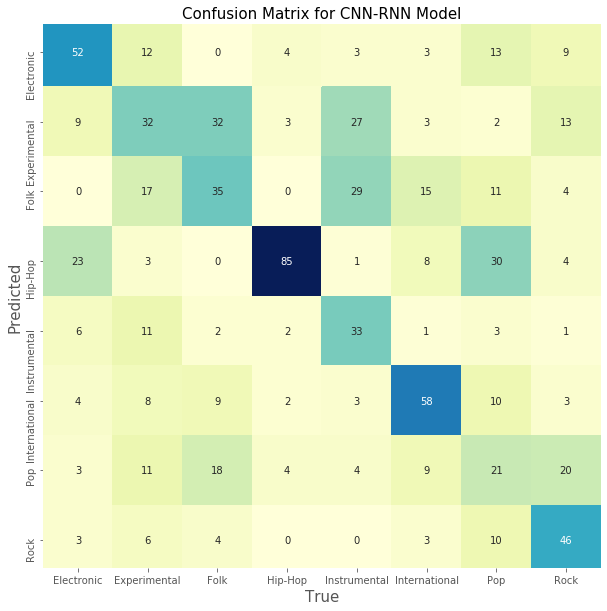

In [13]:
mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlGnBu',
            xticklabels=genre_dict.keys(),
            yticklabels=genre_dict.keys(), ax=ax)
plt.xlabel('True', size=15)
plt.ylabel('Predicted', size=15)
plt.title('Confusion Matrix for CNN-RNN Model', size=15)
ax.set_ylim(8-0.1, 0.1)

In [14]:
tracks = pd.read_csv('../data/fma_metadata/tracks.csv', index_col=0, header=[0,1])
df = tracks[[('set', 'split'), ('set', 'subset'), ('track', 'genre_top')]]
df = df[df[('set','subset')] == 'small']
df['track_id'] = df.index
test = df[df[('set', 'split')]=='test']

In [15]:
df = pd.DataFrame(columns=['True','Predicted'])
df['True'] = y_true
df['Predicted'] = y_pred
df['True'] = df['True'].map(reverse_dict)
df['Predicted'] = df['Predicted'].map(reverse_dict)
df['Track_ID'] = test.index
df['Pred_2'] = np.argsort(preds, axis=1)[:,-2]
df['Pred_2'] = df['Pred_2'].map(reverse_dict)
df['Pred_3'] = np.argsort(preds, axis=1)[:,-3]
df['Pred_3'] = df['Pred_3'].map(reverse_dict)
df['Pred_4'] = np.argsort(preds, axis=1)[:,-4]
df['Pred_4'] = df['Pred_4'].map(reverse_dict)
df['Pred_5'] = np.argsort(preds, axis=1)[:,-5]
df['Pred_5'] = df['Pred_5'].map(reverse_dict)
df['Pred_6'] = np.argsort(preds, axis=1)[:,-6]
df['Pred_6'] = df['Pred_6'].map(reverse_dict)
df['Pred_7'] = np.argsort(preds, axis=1)[:,-7]
df['Pred_7'] = df['Pred_7'].map(reverse_dict)
df['Pred_8'] = np.argsort(preds, axis=1)[:,-8]
df['Pred_8'] = df['Pred_8'].map(reverse_dict)

In [145]:
df[df['True']!=df['Predicted']]

,True,Predicted,Track_ID,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8
0,Rock,Pop,182,Rock,Experimental,International,Instrumental,Hip-Hop,Electronic,Folk
1,International,Hip-Hop,704,Pop,International,Electronic,Experimental,Rock,Instrumental,Folk
3,International,Hip-Hop,706,International,Rock,Pop,Folk,Experimental,Electronic,Instrumental
5,International,Electronic,708,Experimental,Pop,International,Rock,Hip-Hop,Instrumental,Folk
8,Folk,International,892,Rock,Pop,Instrumental,Experimental,Folk,Electronic,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...
790,Pop,Hip-Hop,150017,Experimental,Rock,Pop,Folk,International,Instrumental,Electronic
791,Pop,Electronic,150018,Pop,International,Hip-Hop,Experimental,Instrumental,Rock,Folk
794,Hip-Hop,Experimental,154303,Hip-Hop,Pop,Instrumental,Electronic,International,Rock,Folk
798,Hip-Hop,Electronic,154308,Experimental,Hip-Hop,Pop,Rock,International,Folk,Instrumental


In [150]:
df[(df['True']!=df['Predicted'])&(df['True']!=df['Pred_2'])]

,True,Predicted,Track_ID,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8
1,International,Hip-Hop,704,Pop,International,Electronic,Experimental,Rock,Instrumental,Folk
5,International,Electronic,708,Experimental,Pop,International,Rock,Hip-Hop,Instrumental,Folk
8,Folk,International,892,Rock,Pop,Instrumental,Experimental,Folk,Electronic,Hip-Hop
11,Experimental,Pop,1073,Rock,Folk,International,Experimental,Hip-Hop,Electronic,Instrumental
21,Experimental,Electronic,7377,Hip-Hop,Pop,International,Experimental,Instrumental,Folk,Rock
...,...,...,...,...,...,...,...,...,...,...
779,Pop,Rock,148607,International,Pop,Hip-Hop,Electronic,Instrumental,Folk,Experimental
785,Pop,Rock,148613,Folk,Experimental,Pop,Instrumental,Hip-Hop,Electronic,International
790,Pop,Hip-Hop,150017,Experimental,Rock,Pop,Folk,International,Instrumental,Electronic
798,Hip-Hop,Electronic,154308,Experimental,Hip-Hop,Pop,Rock,International,Folk,Instrumental


In [151]:
(800-284)/800

0.645

In [152]:
df[(df['True']!=df['Predicted'])&(df['True']!=df['Pred_2'])&(df['True']!=df['Pred_3'])]

,True,Predicted,Track_ID,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8
5,International,Electronic,708,Experimental,Pop,International,Rock,Hip-Hop,Instrumental,Folk
8,Folk,International,892,Rock,Pop,Instrumental,Experimental,Folk,Electronic,Hip-Hop
11,Experimental,Pop,1073,Rock,Folk,International,Experimental,Hip-Hop,Electronic,Instrumental
21,Experimental,Electronic,7377,Hip-Hop,Pop,International,Experimental,Instrumental,Folk,Rock
24,Experimental,Folk,7381,Electronic,Pop,International,Experimental,Instrumental,Rock,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...
763,Instrumental,Folk,145762,Pop,Experimental,Instrumental,International,Electronic,Rock,Hip-Hop
775,Hip-Hop,International,148032,Pop,Rock,Folk,Electronic,Experimental,Hip-Hop,Instrumental
776,Experimental,Pop,148082,Instrumental,International,Folk,Experimental,Rock,Electronic,Hip-Hop
785,Pop,Rock,148613,Folk,Experimental,Pop,Instrumental,Hip-Hop,Electronic,International


In [153]:
(800-183)/800

0.77125

In [154]:
df[(df['True']!=df['Predicted'])&(df['True']!=df['Pred_2'])
   &(df['True']!=df['Pred_3'])&(df['True']!=df['Pred_4'])]

,True,Predicted,Track_ID,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8
8,Folk,International,892,Rock,Pop,Instrumental,Experimental,Folk,Electronic,Hip-Hop
11,Experimental,Pop,1073,Rock,Folk,International,Experimental,Hip-Hop,Electronic,Instrumental
21,Experimental,Electronic,7377,Hip-Hop,Pop,International,Experimental,Instrumental,Folk,Rock
24,Experimental,Folk,7381,Electronic,Pop,International,Experimental,Instrumental,Rock,Hip-Hop
33,Folk,Instrumental,10381,Experimental,Electronic,Pop,Folk,Rock,Hip-Hop,International
...,...,...,...,...,...,...,...,...,...,...
720,Electronic,Pop,140922,International,Experimental,Hip-Hop,Instrumental,Electronic,Rock,Folk
732,Rock,Pop,141878,Instrumental,Folk,Experimental,Rock,Electronic,Hip-Hop,International
754,Instrumental,Folk,145458,Rock,Experimental,Pop,Instrumental,International,Electronic,Hip-Hop
775,Hip-Hop,International,148032,Pop,Rock,Folk,Electronic,Experimental,Hip-Hop,Instrumental


In [155]:
(800-126)/800

0.8425

In [156]:
df[(df['True']!=df['Predicted'])&(df['True']!=df['Pred_2'])
   &(df['True']!=df['Pred_3'])&(df['True']!=df['Pred_4'])
   &(df['True']!=df['Pred_5'])]

,True,Predicted,Track_ID,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8
8,Folk,International,892,Rock,Pop,Instrumental,Experimental,Folk,Electronic,Hip-Hop
34,Folk,Experimental,10382,Pop,International,Electronic,Hip-Hop,Instrumental,Rock,Folk
39,Folk,Experimental,10387,International,Instrumental,Pop,Rock,Electronic,Hip-Hop,Folk
41,Folk,International,10389,Experimental,Electronic,Pop,Hip-Hop,Folk,Instrumental,Rock
46,Folk,Experimental,10442,Rock,Pop,Instrumental,International,Folk,Electronic,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...
688,Instrumental,Electronic,134794,International,Pop,Experimental,Folk,Instrumental,Hip-Hop,Rock
690,Instrumental,Hip-Hop,134796,Experimental,Electronic,International,Pop,Folk,Rock,Instrumental
707,Instrumental,Pop,138026,Electronic,Experimental,International,Folk,Hip-Hop,Rock,Instrumental
720,Electronic,Pop,140922,International,Experimental,Hip-Hop,Instrumental,Electronic,Rock,Folk


In [157]:
(800-69)/800

0.91375

In [72]:
df[(df['True']=='Pop')&(df['Predicted']=='Rock')]

,True,Predicted,Track_ID,Pred_2,Pred_3,Pred_4,Pred_5
172,Pop,Rock,28802,Instrumental,Folk,Electronic,Hip-Hop
359,Pop,Rock,67333,Hip-Hop,Pop,Experimental,Electronic
361,Pop,Rock,67336,Hip-Hop,Instrumental,Pop,Experimental
451,Pop,Rock,91468,Hip-Hop,Experimental,Folk,Electronic
614,Pop,Rock,120206,Electronic,International,Instrumental,Folk
646,Pop,Rock,127183,Electronic,Instrumental,Hip-Hop,International
651,Pop,Rock,127188,Hip-Hop,Electronic,Experimental,Pop
779,Pop,Rock,148607,Folk,Instrumental,Electronic,Hip-Hop
781,Pop,Rock,148609,International,Experimental,Instrumental,Folk
785,Pop,Rock,148613,Electronic,Hip-Hop,Instrumental,Pop


In [19]:
plt.style.use('classic')

In [26]:
def pareto_plot(df, title, genre=None, filename=None):
    if genre:
        gen = df[df['True']==genre].copy()
        gen.set_index('Track_ID', inplace=True)
        gen.reset_index(inplace=True)
        x = [1,2,3,4,5,6,7,8]
        y1 = [gen[gen[col]==genre].shape[0] for col in gen.columns[2:]]
        y2 = (np.array(y1)/100).cumsum()
        f = [f'{x:,.0%}' for x in y2]
    else:
        df.set_index('Track_ID', inplace=True)
        df.reset_index(inplace=True)
        x = [1,2,3,4,5,6,7,8]
        y1 = [df[df[col]==df['True']].shape[0] for col in df.columns[2:]]
        y2 = (np.array(y1)/800).cumsum()
        f = [f'{x:,.2%}' for x in y2]
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x, y1, color='blue', alpha=0.5)
    ax2 = ax.twinx()
    ax2.plot(x, y2, color='red', marker='o', linestyle='--')
    ax2.set_ylim(.1,1)
    ax2.set_yticklabels([])
    for i in range(8):
        ax2.annotate(f[i], (x[i]+0.2, y2[i]-0.01), fontweight='heavy')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Number Correct')
    ax.set_title(f'Prediction Accuracy for {title}')
    plt.tight_layout()
    if filename:
        plt.savefig('../images/' + filename + '.png')

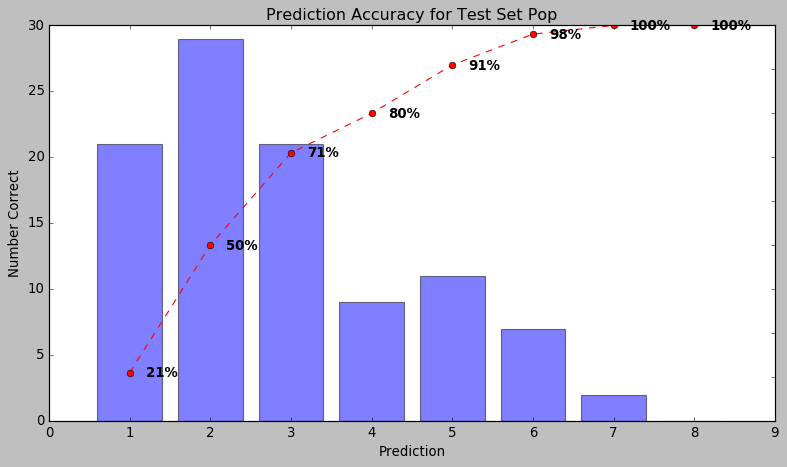

In [27]:
pareto_plot(df, 'Test Set Pop', genre='Pop', filename='pop_pareto')

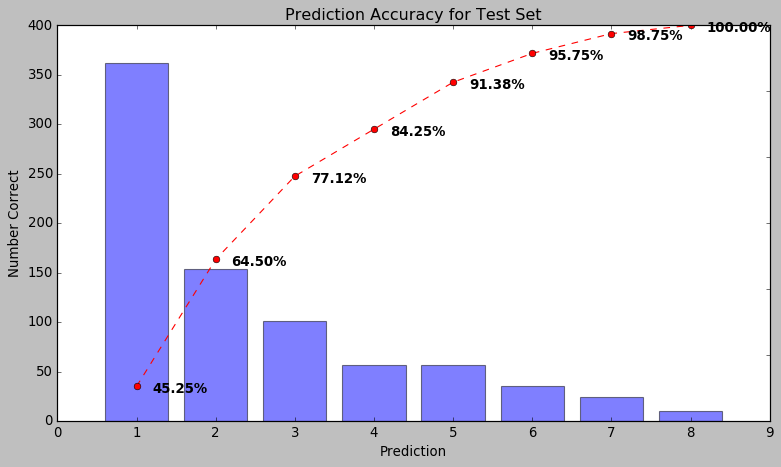

In [233]:
pareto_plot(df, 'CNN-RNN Parallel', filename='pareto_all')

In [235]:
npzfile = np.load('../saved_variables/test.npz')
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
preds = crnn_model.predict(X_test)
df = pd.DataFrame(columns=['True','Predicted'])
df['True'] = y_test
df['Predicted'] = np.argsort(preds, axis=1)[:,-1]
df['True'] = df['True'].map(reverse_dict)
df['Predicted'] = df['Predicted'].map(reverse_dict)
df['Track_ID'] = test.index
df['Pred_2'] = np.argsort(preds, axis=1)[:,-2]
df['Pred_2'] = df['Pred_2'].map(reverse_dict)
df['Pred_3'] = np.argsort(preds, axis=1)[:,-3]
df['Pred_3'] = df['Pred_3'].map(reverse_dict)
df['Pred_4'] = np.argsort(preds, axis=1)[:,-4]
df['Pred_4'] = df['Pred_4'].map(reverse_dict)
df['Pred_5'] = np.argsort(preds, axis=1)[:,-5]
df['Pred_5'] = df['Pred_5'].map(reverse_dict)
df['Pred_6'] = np.argsort(preds, axis=1)[:,-6]
df['Pred_6'] = df['Pred_6'].map(reverse_dict)
df['Pred_7'] = np.argsort(preds, axis=1)[:,-7]
df['Pred_7'] = df['Pred_7'].map(reverse_dict)
df['Pred_8'] = np.argsort(preds, axis=1)[:,-8]
df['Pred_8'] = df['Pred_8'].map(reverse_dict)

In [236]:
df

,True,Predicted,Track_ID,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8
0,Rock,Pop,182,Rock,Instrumental,Experimental,International,Electronic,Folk,Hip-Hop
1,International,International,704,Hip-Hop,Electronic,Pop,Experimental,Rock,Folk,Instrumental
2,International,International,705,Pop,Hip-Hop,Folk,Experimental,Electronic,Rock,Instrumental
3,International,International,706,Hip-Hop,Pop,Electronic,Experimental,Rock,Folk,Instrumental
4,International,Hip-Hop,707,Experimental,Rock,Pop,Folk,International,Electronic,Instrumental
...,...,...,...,...,...,...,...,...,...,...
795,Hip-Hop,Hip-Hop,154305,Electronic,Experimental,Pop,International,Instrumental,Rock,Folk
796,Hip-Hop,International,154306,Electronic,Hip-Hop,Experimental,Pop,Instrumental,Folk,Rock
797,Hip-Hop,Hip-Hop,154307,International,Electronic,Pop,Experimental,Folk,Instrumental,Rock
798,Hip-Hop,International,154308,Electronic,Hip-Hop,Pop,Instrumental,Experimental,Folk,Rock


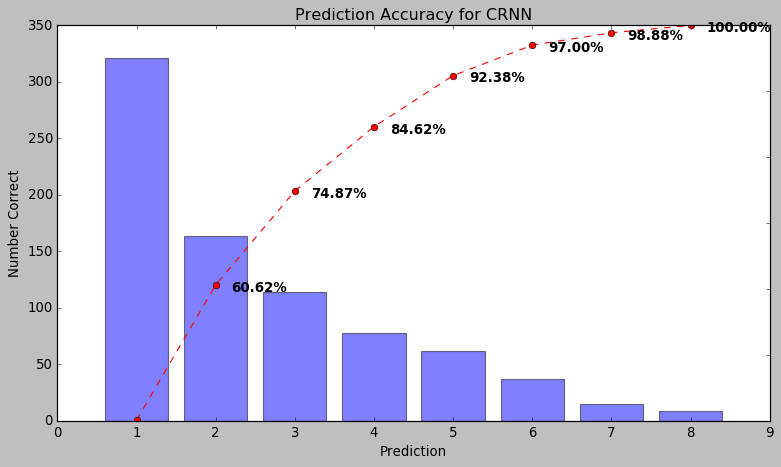

In [237]:
pareto_plot(df, 'CRNN', filename='pareto_crnn')